In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer, FeatureHasher

from transformers import *
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

In [2]:
# Load Data
train_pd  = pd.read_csv('data/train.csv', index_col=0)
test_pd  = pd.read_csv('data/test.csv', index_col=0)

labels = train_pd.Hazard
train_pd.drop('Hazard', axis=1, inplace=True)

columns = train_pd.columns
test_ind = test_pd.index

train_pd_orig = train_pd.copy()
test_pd_orig = test_pd.copy()

In [3]:
train_pd_orig

,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,T1_V10,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,
1,15,3,2,N,B,N,B,B,D,7,...,2,37,1,11,6,Y,N,E,2,2
2,16,14,5,H,B,N,B,B,C,12,...,2,22,1,18,5,Y,Y,E,2,1
3,10,10,5,N,K,N,B,B,E,12,...,6,37,2,14,6,Y,Y,E,6,1
4,18,18,5,N,K,N,B,B,E,3,...,2,25,1,1,6,Y,N,C,2,6
5,13,19,5,N,H,N,B,B,E,7,...,1,22,1,2,7,N,N,E,1,1
12,14,12,2,N,K,N,B,B,E,12,...,1,37,1,5,7,N,N,A,1,9
15,8,17,1,E,K,N,B,B,E,8,...,2,25,1,20,3,Y,N,D,2,11
19,14,20,4,E,K,N,B,B,E,3,...,2,40,1,18,7,Y,N,E,3,2
21,8,2,2,W,C,N,D,B,D,8,...,1,34,1,13,5,N,N,A,2,1


In [4]:
print 'Unique Values'
cc = 0
for col in train_pd.columns:
    col_vals = sorted(train_pd[col].unique())
    cc += len(col_vals)
    print col + '\t|(%d) \t' % len(col_vals), col_vals
print 'Sum of # of unique values: ', cc

Unique Values
T1_V1	|(19) 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
T1_V2	|(24) 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
T1_V3	|(9) 	[1, 2, 3, 4, 5, 6, 7, 8, 9]
T1_V4	|(8) 	['B', 'C', 'E', 'G', 'H', 'N', 'S', 'W']
T1_V5	|(10) 	['A', 'B', 'C', 'D', 'E', 'H', 'I', 'J', 'K', 'L']
T1_V6	|(2) 	['N', 'Y']
T1_V7	|(4) 	['A', 'B', 'C', 'D']
T1_V8	|(4) 	['A', 'B', 'C', 'D']
T1_V9	|(6) 	['B', 'C', 'D', 'E', 'F', 'G']
T1_V10	|(5) 	[2, 3, 7, 8, 12]
T1_V11	|(12) 	['A', 'B', 'D', 'E', 'F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
T1_V12	|(4) 	['A', 'B', 'C', 'D']
T1_V13	|(4) 	[5, 10, 15, 20]
T1_V14	|(5) 	[0, 1, 2, 3, 4]
T1_V15	|(8) 	['A', 'C', 'D', 'F', 'H', 'N', 'S', 'W']
T1_V16	|(18) 	['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R']
T1_V17	|(2) 	['N', 'Y']
T2_V1	|(100) 	[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

In [23]:
train_pd = train_pd_orig.copy()
test_pd = test_pd_orig.copy()
# One hot encode the str columns
for col in train_pd.columns:
    if type(train_pd[col][1]) is str:
        enc = pd.get_dummies(pd.concat([train_pd[col], test_pd[col]]))
        enc.columns = ['-'.join([col, enc_col]) for enc_col in enc.columns]
        train_pd = pd.concat([train_pd, enc[:len(train_pd)]], axis=1)
        test_pd = pd.concat([test_pd, enc[-len(test_pd):]], axis=1)
        
        le = LabelEncoder().fit(pd.concat([train_pd[col], test_pd[col]]))
        # Replace with label encoded
        train_pd[col] = le.transform(train_pd[col])
        test_pd[col] = le.transform(test_pd[col])
#         # Drop
#         train_pd.drop(col, axis=1, inplace=True)
#         test_pd.drop(col, axis=1, inplace=True)

In [25]:
# Save things
import cPickle as pickle
train_pd.save('saved/train_pd_le_and_oh_enc.p')
test_pd.save('saved/test_pd_le_and_oh_enc.p')
labels.save('saved/labels.p')
pickle.dump(test_ind, open('saved/test_ind.p', 'wb'))

In [26]:
train_pd.shape

(50999, 127)

## One Hot Encoding EVERYTHING


In [42]:
train_pd = train_pd_orig.copy()
test_pd = test_pd_orig.copy()
# One hot encode EVERYTHING
for col in train_pd.columns:
    enc = pd.get_dummies(pd.concat([train_pd[col], test_pd[col]]))
    enc.columns = ['-'.join([col, str(enc_col)]) for enc_col in enc.columns]
    train_pd = pd.concat([train_pd, enc[:len(train_pd)].astype(bool)], axis=1)
    train_pd.drop(col, axis=1, inplace=True)
    test_pd = pd.concat([test_pd, enc[-len(test_pd):].astype(bool)], axis=1)
    test_pd.drop(col, axis=1, inplace=True)

In [43]:
# Save all one hot
train_pd.save('saved/train_pd_binary_enc.p')
test_pd.save('saved/test_pd_binary_enc.p')

## Label Order Encode

In [17]:
train_pd = train_pd_orig.copy()
test_pd = test_pd_orig.copy()
# Label encode
for col in train_pd.columns:
    le = LabelEncoder().fit(pd.concat([train_pd[col], test_pd[col]]))
    train_pd[col] = le.transform(train_pd[col])
    test_pd[col] = le.transform(test_pd[col])



In [21]:
# Save all one hot
train_pd.save('saved/train_pd_l_enc.p')
test_pd.save('saved/test_pd_l_enc.p')

/usr/lib/python2.7/site-packages/pandas/core/generic.py:984: FutureWarning: save is deprecated, use to_pickle
  warnings.warn("save is deprecated, use to_pickle", FutureWarning)


# Binning target values

(array([  0.00000000e+00,   1.89810000e+04,   6.14500000e+03,
          2.02500000e+03,   8.27300000e+03,   3.64500000e+03,
          1.40700000e+03,   3.28400000e+03,   1.78300000e+03,
          7.39000000e+02,   1.31100000e+03,   8.00000000e+02,
          3.79000000e+02,   5.60000000e+02,   3.89000000e+02,
          1.74000000e+02,   2.35000000e+02,   1.94000000e+02,
          1.03000000e+02,   1.38000000e+02,   9.80000000e+01,
          3.10000000e+01,   7.10000000e+01,   4.20000000e+01,
          1.40000000e+01,   4.40000000e+01,   2.50000000e+01,
          5.00000000e+00,   3.20000000e+01,   1.40000000e+01,
          9.00000000e+00,   8.00000000e+00,   6.00000000e+00,
          1.00000000e+00,   8.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
        

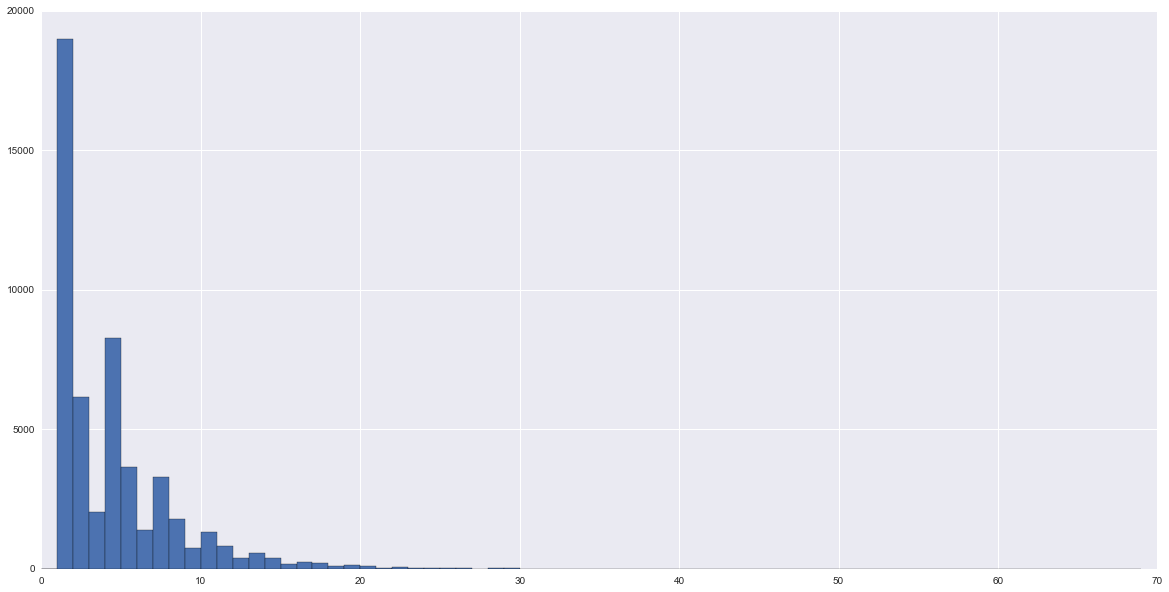

In [5]:
plt.figure(figsize=(20,10))
plt.hist(np.array(labels), bins=np.arange(70))

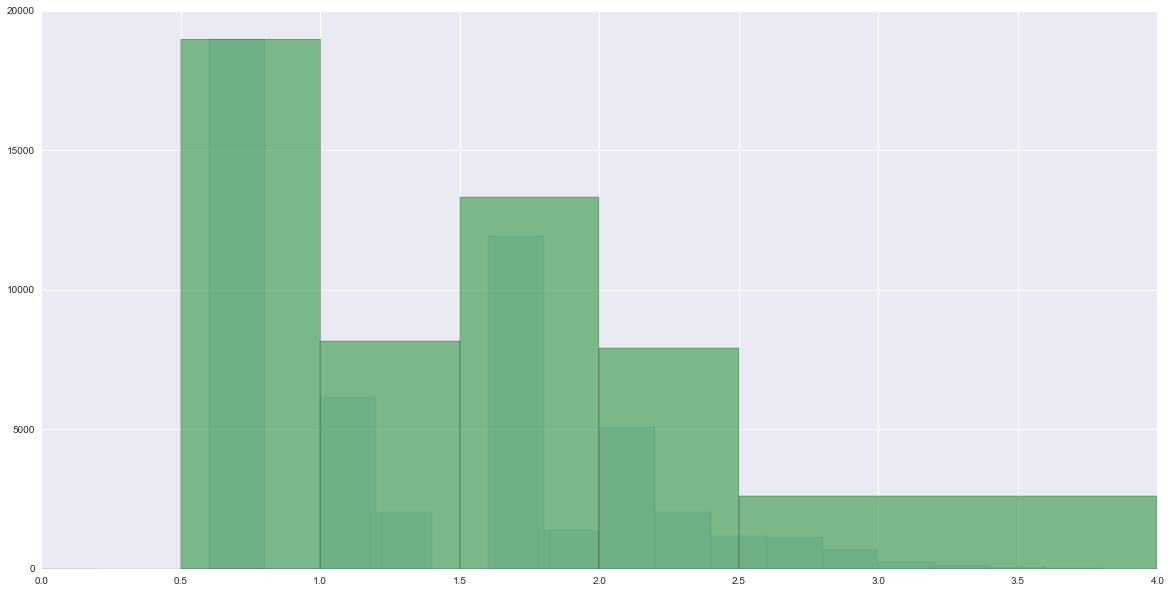

In [32]:
from transformers import *

plt.figure(figsize=(20,10))
y_raw = np.array(labels)


plt.hist(LogTformer().fit_transform(y_raw), 
         bins=np.arange(0,4,0.2),
         alpha=0.3);

bins = [0.5, 1, 1.5, 2.0, 2.5,]

plt.hist(LogTformer().fit_transform(y_raw), 
#          bins=np.arange(0,4,0.2),
         bins=bins,
         alpha=0.75);


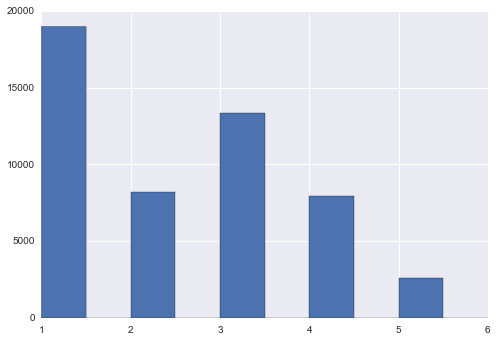

In [36]:
y_binned = np.digitize(LogTformer().fit_transform(y_raw), bins=bins)
plt.hist(y_binned)

np.save('saved/y_binned.npy', y_binned)